<a href="https://colab.research.google.com/github/prcstak/service_text_recognition/blob/main/notebooks/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [51]:
! pip install transformers
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image



# Upload image

In [52]:
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))

Saving Screenshot 2024-04-02 114641.png to Screenshot 2024-04-02 114641 (1).png


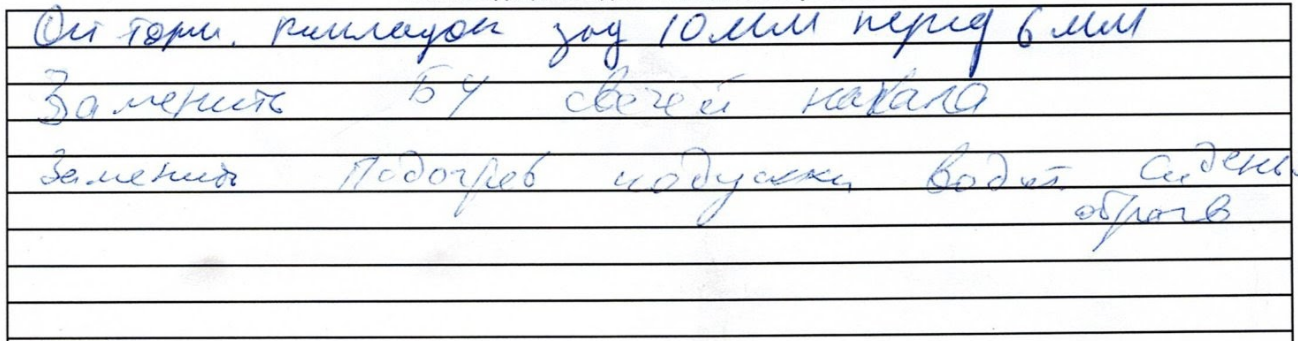

In [57]:
image = cv2.imread(f'/content/{filename}')
cv2_imshow(image)

# Remove lines

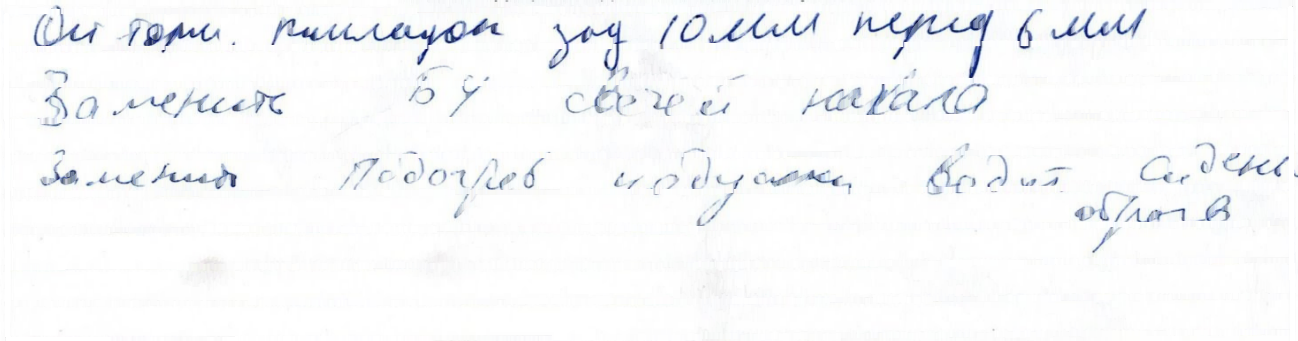

In [58]:
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Remove horizontal
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(image, [c], -1, (255,255,255), 2)

# Repair image
repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
result = 255 - cv2.morphologyEx(255 - image, cv2.MORPH_CLOSE, repair_kernel, iterations=1)

gray = cv2.cvtColor(result,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Remove vertical
verticall_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,25))
detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, verticall_kernel, iterations=2)
cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(result, [c], -1, (255,255,255), 2)

cv2_imshow(result)

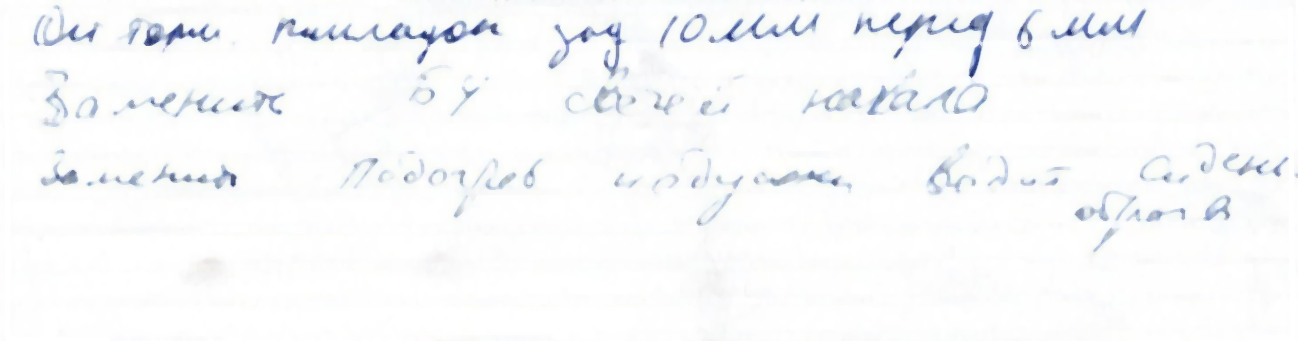

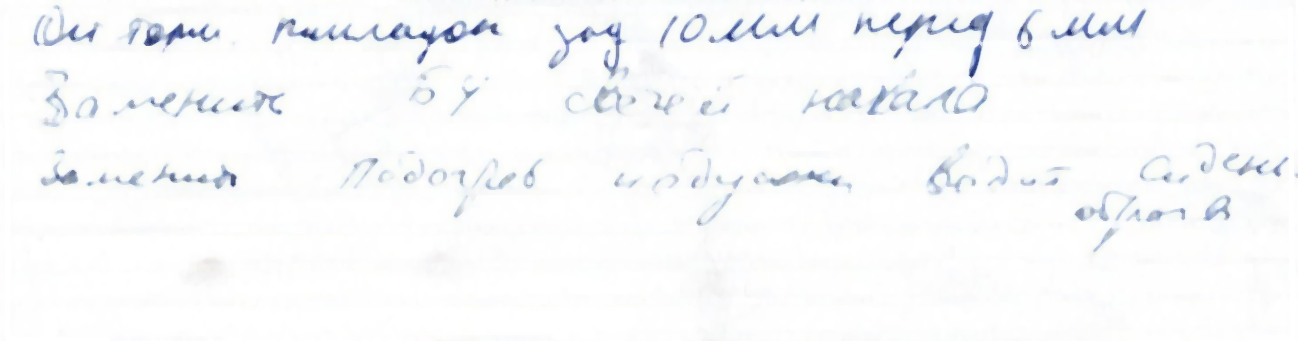

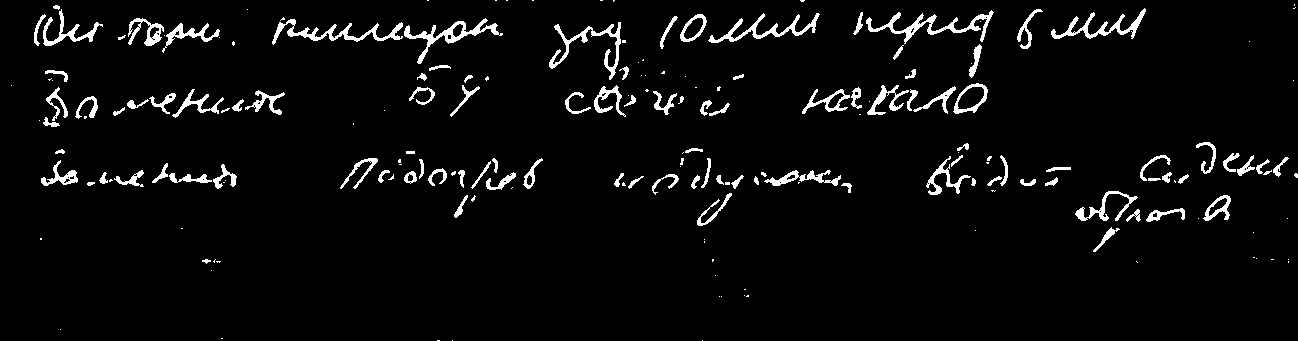

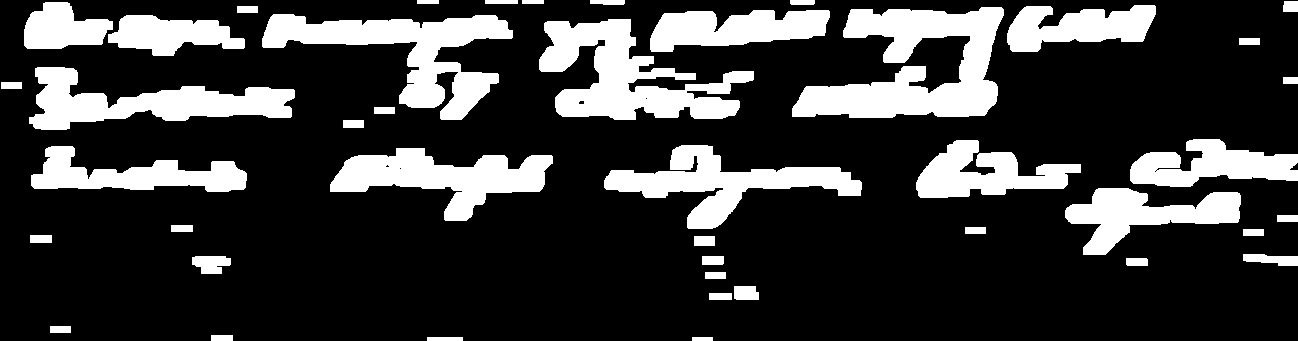

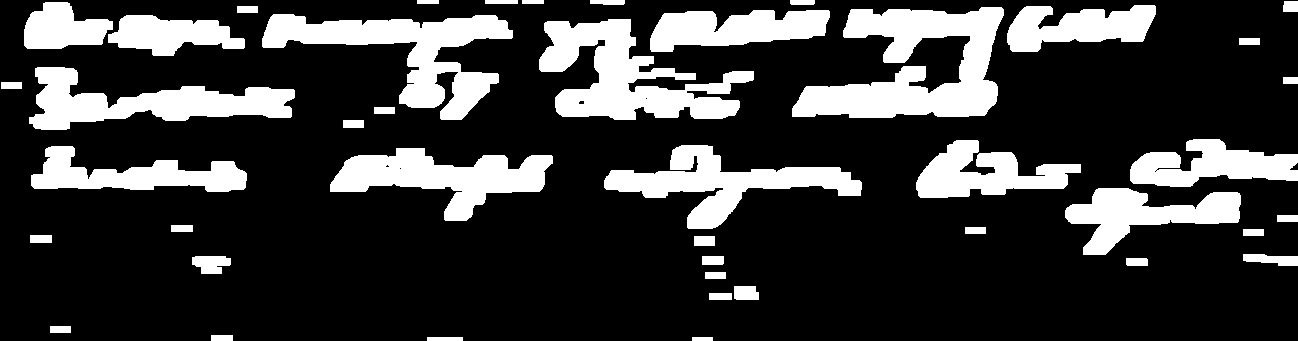

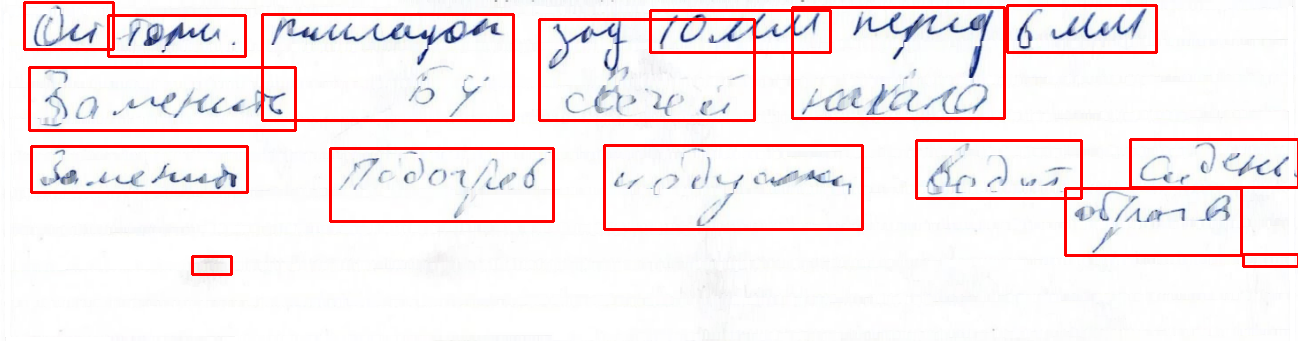

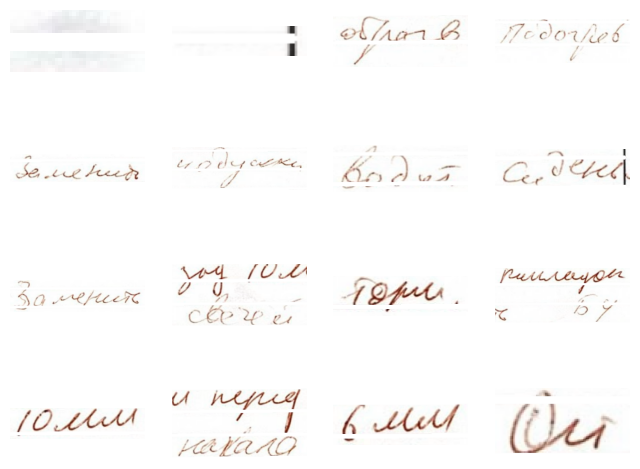

In [59]:
blurred_img = cv2.medianBlur(result, 5)

kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(blurred_img, kernel, iterations=1)
output = cv2.dilate(erosion, kernel, iterations=1)
cv2_imshow(output)
# load image
img = output
cv2_imshow(img)

# convert to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# threshold the grayscale image
# thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 7, 3)
cv2_imshow(thresh)
# use morphology erode to blur horizontally

# kernel = np.ones((3,3),np.uint8)
# erosion = cv2.erode(thresh, kernel, iterations = 1)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
morph = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)
cv2_imshow(morph)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)
cv2_imshow(morph)

# find contours
cntrs = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cntrs = cntrs[0] if len(cntrs) == 2 else cntrs[1]

# Draw contours
bboxes = []
for c in cntrs:
  area = cv2.contourArea(c)
  if area > 350:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 2)
    bboxes.append((x,y,w,h))

cv2_imshow(result)

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = len(bboxes)//4+1
words = []
i = 1
for b in bboxes:
  x, y, w, h = b
  cropped_image = image[y:y+h, x:x+w]
  words.append(cropped_image)
  fig.add_subplot(rows, columns, i)
  plt.axis('off')
  plt.imshow(cropped_image)
  i+=1

plt.show()

# write result to disk
#cv2.imwrite("test_text_threshold.png", thresh)
#cv2.imwrite("test_text_morph.png", morph)
#cv2.imwrite("test_text_lines.jpg", result)

In [60]:
processor = AutoProcessor.from_pretrained("raxtemur/trocr-base-ru")
model = VisionEncoderDecoderModel.from_pretrained("raxtemur/trocr-base-ru")

# image = Image.open("/content/line.png").convert("RGB")
for word in words:
  image = Image.fromarray(word)

  # training
  # model.config.decoder_start_token_id = processor.tokenizer.eos_token_id
  # model.config.pad_token_id = processor.tokenizer.pad_token_id
  # model.config.vocab_size = model.config.decoder.vocab_size

  pixel_values = processor(image, return_tensors="pt").pixel_values
  # text = "Привет!"
  # labels = processor.tokenizer(text, return_tensors="pt").input_ids
  # outputs = model(pixel_values=pixel_values, labels=labels)
  # loss = outputs.loss

  # inference (generation)
  generated_ids = model.generate(pixel_values)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]


  print(generated_text)

проект
проект
облагв
Подогреб
Земений.
и обдухов,
водит
Сидень
За менить
свечом
торм.
Гимладор
10 мм
начала
6 мм
Ой
